In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import numpy as np
import os
import gzip

import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
train_file = './Titanic.train.csv'
eval_file = './Titanic.valid.csv'

from sklearn.model_selection import train_test_split
train_df = pd.read_csv(train_file)
eval_df = pd.read_csv(eval_file)

print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [40]:
train_df.pop('PassengerId')
eval_df.pop('PassengerId')
train_df.pop('Name')
eval_df.pop('Name')
y_train = train_df.pop('Survived')
y_eval = eval_df.pop('Survived')
print(train_df.head())

0        1
1        2
2        3
3        4
4        5
      ... 
594    595
595    596
596    597
597    598
598    599
Name: PassengerId, Length: 599, dtype: int64

0      600
1      601
2      602
3      603
4      604
      ... 
287    887
288    888
289    889
290    890
291    891
Name: PassengerId, Length: 292, dtype: int64

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
594                              Chapman, Mr. John Henry
595                          Van Impe, Mr. Jean Baptiste
596                           Leitch, Miss. Jessie Wills
597                                  Johnson, Mr. Alfred
598                                    Boulos, Mr. Hanna
Name: Name, Length: 599, dtype: object

0           Duff Gordon, Sir. Cosmo Edmund ("Mr Morgan")
1      Jacobsohn, Mrs. Sidney Samuel (Amy Frances Chr...
2                                   Slabenoff, Mr. Petco
3                              Harrington, Mr. Charles H
4                              Torber, Mr. Ernst William
                             ...                        
287                                Montvila, Rev. Juozas
288                         Graham, Miss. Margaret Edith
289             Johnston, Miss. Catherine Helen "Carrie"
290                                Behr, Mr. Karl Howell
291                                  Dooley, Mr. Patrick
Name: Name, Length: 292, dtype: object

   Pclass     Sex   Age  SibSp  Parch            Ticket     Fare Cabin  \
0       3    male  22.0      1      0         A/5 21171   7.2500   NaN   
1       1  female  38.0      1      0          PC 17599  71.2833   C85   
2       3  female  26.0      0      0  STON/O2. 3101282   7.9250   NaN   
3       1  female  35.0      1      0            113803  53.1000  C123   
4       3    male  35.0      0      0            373450   8.0500   NaN   

  Embarked  
0        S  
1        C  
2        S  
3        S  
4        S  


In [41]:
# 计算统计量
train_df.describe()
print(train_df.shape, eval_df.shape)

,Pclass,Age,SibSp,Parch,Fare
count,599.000000,473.000000,599.000000,599.000000,599.000000
mean,2.310518,29.742072,0.537563,0.375626,31.804159
std,0.834302,14.523569,1.097965,0.774256,46.313609
min,1.000000,0.750000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.925000
50%,3.000000,28.000000,0.000000,0.000000,14.500000
75%,3.000000,38.000000,1.000000,0.000000,30.500000
max,3.000000,71.000000,8.000000,5.000000,512.329200


(599, 9) (292, 9)


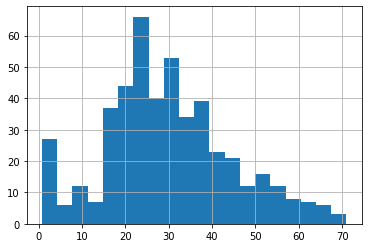

In [42]:
train_df.Age.hist(bins = 20)

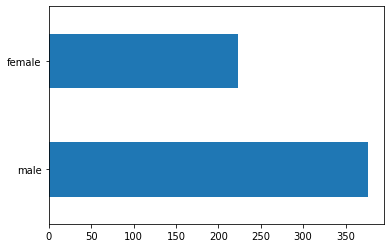

In [43]:
# 要是和上一个单元放在一个单元一起执行，会出问题
train_df.Sex.value_counts().plot(kind = 'barh')

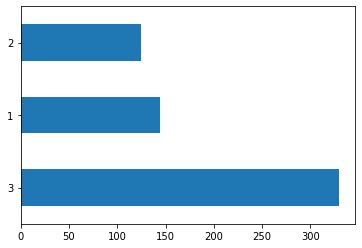

In [44]:
# 避免与method重名，也可以这么取
train_df['Pclass'].value_counts().plot(kind = 'barh')

Sex
female    0.748879
male      0.180851
Name: Survived, dtype: float64

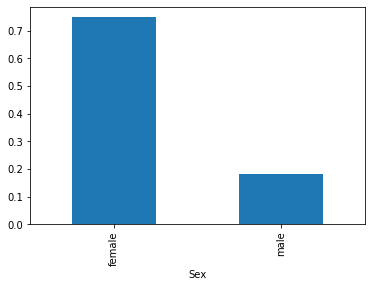

In [45]:
# 先分组，再按组计算均值
pd.concat([train_df, y_train], axis=1).groupby('Sex').Survived.mean()
pd.concat([train_df, y_train], axis=1).groupby('Sex').Survived.mean().plot(kind='bar')

In [ ]:
# feature_column 针对列数据进行封装
# 离散、连续
# Pclass Sex Age SibSp Parch Ticket Fare Cabin
categorical_columns = ['Sex', 'SibSp', 'Parch', 'Pclass', 'Cabin', 'Embarked', 'Ticket']
numeric_columns = ['Age', 'Fare']
feature_columns = []
# 离散
for categorical_column in categorical_columns:
    vocab = train_df[categorical_column].unique()
    print(categorical_column, vocab)
    # tf.feature_column可以嵌套，类似于pipeline
    feature_columns.append(
        tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_vocabulary_list(
                categorical_column, vocab)))
# 连续
for numeric_column in numeric_columns:
    feature_columns.append(
        tf.feature_column.numeric_column(
            numeric_column, dtype=tf.float32))

In [ ]:
# 生成dataset
def make_dataset(data_df, label_df, epochs=10, shuffle=True,batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(
        # 需要将DataFrame转为字典
        (dict(data_df), label_df))
    if shuffle:
        dataset = dataset.shuffle(10000)
    dataset = dataset.repeat(epochs).batch(batch_size)
    return dataset

train_dataset = make_dataset(train_df, y_train, batch_size=5)
# Can't convert Python sequence with mixed types to Tensor.

# 获取一个值，打印
# 结果：字典{"feature_name": tf.tensor:}
for x, y in train_dataset.take(1):
    print(x, y)

In [ ]:
# feature_columns与dataset结合使用, 将feature_columns定义的变化规则运用到dataset中的每一个数据
# keras.layers.DenseFeatures()
for x, y in train_dataset:
    age_column = feature_columns[7]
    gender_column = feature_columns[0]
    keras.layers.DenseFeatures(age_column)(x).numpy()
    keras.layers.DenseFeatures(gender_column)(x).numpy()  # one-hot编码[1, 0], [0, 1]

In [ ]:
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = keras.optimizers.SGD(lr=0.01),
              metrics = ['accuracy'])

In [ ]:
# 1、model.fit  steps_per_epoch过大可能因为数据不够而终止
# 2、model --> estimator --> train
train_dataset = make_dataset(train_df, y_train, epochs = 100)
eval_dataset = make_dataset(eval_df, y_eval, epoch = 1, shuffle = False)
history = model.fit(train_dataset, validation_data = eval_dataset,
                    steps_per_epoch = 20, validation_steps =8, epochs = 100)

estimator = keras.estimator.model_to_estimator(model)
# 1、input_fn：def定义的具体函数， 或lambda匿名函数
# 2、return  a、(feature, labels) b、dataset -> (feature, label)
# 用lambda对make_dataset封装，使其没有参数
estimator.train(input_fn = lambda : make_dataset(train_df, y_train, epochs=100))
# alpha版会出现字典中的名字没有被保存，而是转换成了input1，input2，...
# https://www.jianshu.com/p/463cb4a602a0